In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/RobertWalraven-ESG'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
len(all_data)

95

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,target,target_end_date,location,type,quantile,value
8738,2020-07-06,1 wk ahead inc case,2020-07-11,42,point,NaN,667.059400
8794,2020-07-06,2 wk ahead inc case,2020-07-18,42,point,NaN,483.635200
8850,2020-07-06,3 wk ahead inc case,2020-07-25,42,point,NaN,362.598100
8906,2020-07-06,4 wk ahead inc case,2020-08-01,42,point,NaN,299.754100
8738,2020-07-07,1 wk ahead inc case,2020-07-18,42,point,NaN,3035.557892


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,forecast_date,target,target_end_date,location,type,quantile,value
8738,2020-07-06,1 wk ahead inc case,2020-07-11,42,point,NaN,667.059400
8794,2020-07-06,2 wk ahead inc case,2020-07-18,42,point,NaN,483.635200
8738,2020-07-07,1 wk ahead inc case,2020-07-18,42,point,NaN,3035.557892
8738,2020-07-12,1 wk ahead inc case,2020-07-18,42,point,NaN,6143.779053
8850,2020-07-06,3 wk ahead inc case,2020-07-25,42,point,NaN,362.598100
...,...,...,...,...,...,...,...
9152,2022-03-07,3 wk ahead inc case,2022-03-26,42,point,NaN,794.000000
9096,2022-03-14,2 wk ahead inc case,2022-03-26,42,point,NaN,982.000000
9152,2022-03-14,3 wk ahead inc case,2022-04-02,42,point,NaN,521.000000
9208,2022-03-07,4 wk ahead inc case,2022-04-02,42,point,NaN,420.000000


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(93, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2020-07-11,2020-07-06,1 wk ahead inc case,42,point,NaN,667.059400,95.294200
1,2020-07-18,2020-07-12,1 wk ahead inc case,42,point,NaN,6143.779053,877.682722
2,2020-07-25,2020-07-20,1 wk ahead inc case,42,point,NaN,5239.152527,748.450361
3,2020-08-01,2020-07-27,1 wk ahead inc case,42,point,NaN,5014.430000,716.347143
4,2020-08-08,2020-08-03,1 wk ahead inc case,42,point,NaN,4472.160000,638.880000


In [12]:
df_weekly.tail(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
79,2022-01-29,2022-01-24,1 wk ahead inc case,42,point,NaN,165198.0,23599.714286
80,2022-02-05,2022-01-31,1 wk ahead inc case,42,point,NaN,86587.0,12369.571429
81,2022-02-12,2022-02-07,1 wk ahead inc case,42,point,NaN,30840.0,4405.714286
82,2022-02-19,2022-02-14,1 wk ahead inc case,42,point,NaN,18224.0,2603.428571
83,2022-02-26,2022-02-21,1 wk ahead inc case,42,point,NaN,10518.0,1502.571429


In [13]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[95.2942, 95.2942, 95.2942, 95.2942, 95.2942, 95.2942, 95.2942, 877.6827218191971, 877.6827218191971, 877.6827218191971, 877.6827218191971, 877.6827218191971, 877.6827218191971, 877.6827218191971, 748.4503609793528, 748.4503609793528, 748.4503609793528, 748.4503609793528, 748.4503609793528, 748.4503609793528, 748.4503609793528, 716.3471428571429, 716.3471428571429, 716.3471428571429, 716.3471428571429, 716.3471428571429, 716.3471428571429, 716.3471428571429, 638.88, 638.88, 638.88, 638.88, 638.88, 638.88, 638.88, 862.3757142857143, 862.3757142857143, 862.3757142857143, 862.3757142857143, 862.3757142857143, 862.3757142857143, 862.3757142857143, 609.5757142857143, 609.5757142857143, 609.5757142857143, 609.5757142857143, 609.5757142857143, 609.5757142857143, 609.5757142857143, 507.40999999999997, 507.40999999999997, 507.40999999999997, 507.40999999999997, 507.40999999999997, 507.40999999999997, 507.40999999999997, 435.79857142857145, 435.79857142857145, 435.79857142857145, 435.79857142857

In [14]:
len(predictions)

586

In [19]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-07-11') & (df1['Date'] <= '2022-02-16')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-07-11,1320,1533.8,198586,25603978,225.5,252.8,28684.6,2860489,-5275.682283,2774.207671
1,2020-07-12,806,1501.4,199392,25603978,178.6,259.3,28863.7,2860489,-5275.682283,2774.207671
2,2020-07-13,1828,1533.2,201220,25603978,303.9,265.9,29167.7,2860489,-5275.682283,2774.207671
3,2020-07-14,1976,1558.5,203196,25603978,358.0,272.8,29525.8,2860489,-5275.682283,2774.207671
4,2020-07-15,1660,1582.0,204856,25603978,261.2,277.8,29787.0,2860489,-5275.682283,2774.207671


In [20]:
len(df1_copy)

586

In [21]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [23]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [25]:
merged_df_new.shape

(586, 12)

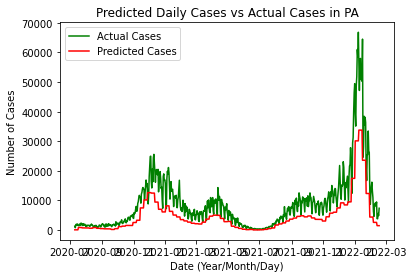

In [26]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [27]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

577
0.984641638225256
9
0.015358361774744034
586
[0.9278074242424242, 0.8817689826302729, 0.947869693654267, 0.9517741902834008, 0.9425938554216867, 0.9540085907335907, 0.9397634639696586, 0.43155264130881016, 0.4069711339059479, 0.5735263742375136, 0.43593655410077303, 0.5129396660270826, 0.6315353812681792, 0.602138385394743, 0.5425120042913492, 0.5127276295707338, 0.6566741463397464, 0.5232800248539154, 0.5901148077878681, 0.6283761862068755, 0.5809348482758383, 0.45731277056277053, 0.37924857638029214, 0.5720745861068441, 0.5046008693934004, 0.557810405643739, 0.5324104811637449, 0.5632029616724739, 0.5894087403598972, 0.48394184168012927, 0.6094865525672372, 0.6398647125140924, 0.6898640776699029, 0.6215165876777251, 0.6228571428571428, 0.36960839598997497, 0.02224975704567545, 0.33866893076248905, 0.2942915595043255, 0.4443455449189985, 0.4157346109175378, 0.4610151785714286, 0.4920202380952381, 0.28116071428571426, 0.48688912938912937, 0.40002390326209225, 0.5230236977420076, 0.

In [28]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.07219257575757576, 0.11823101736972708, 0.05213030634573301, 0.04822580971659918, 0.05740614457831328, 0.04599140926640932, 0.0602365360303414, 0.5684473586911898, 0.5930288660940521, 0.4264736257624864, 0.564063445899227, 0.48706033397291737, 0.3684646187318208, 0.39786161460525704, 0.45748799570865084, 0.4872723704292662, 0.3433258536602536, 0.47671997514608455, 0.40988519221213193, 0.3716238137931245, 0.4190651517241617, 0.5426872294372295, 0.6207514236197078, 0.42792541389315586, 0.49539913060659957, 0.44218959435626104, 0.4675895188362551, 0.43679703832752614, 0.4105912596401028, 0.5160581583198707, 0.39051344743276284, 0.3601352874859076, 0.3101359223300971, 0.3784834123222749, 0.3771428571428572, 0.630391604010025, 0.9777502429543246, 0.661331069237511, 0.7057084404956745, 0.5556544550810014, 0.5842653890824623, 0.5389848214285714, 0.5079797619047619, 0.7188392857142858, 0.5131108706108707, 0.5999760967379077, 0.47697630225799237, 0.35815259358737617, 0.36633155906593395, 0.3

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

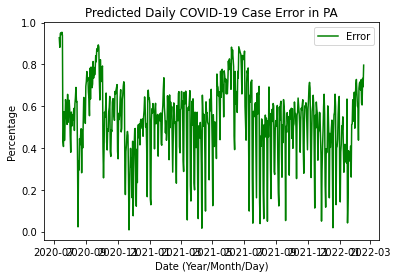

In [30]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

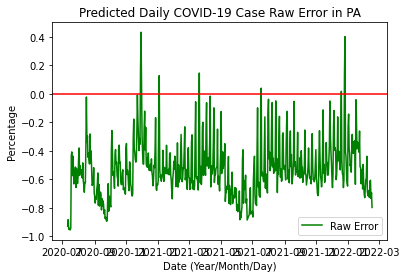

In [31]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

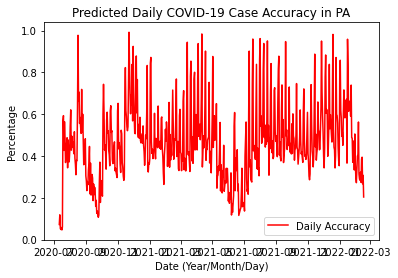

In [32]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [33]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [34]:
len(weeklyDateList)

84

In [35]:
#del averageWeeklyAccuracy[-1:]
len(averageWeeklyAccuracy)

84

In [36]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

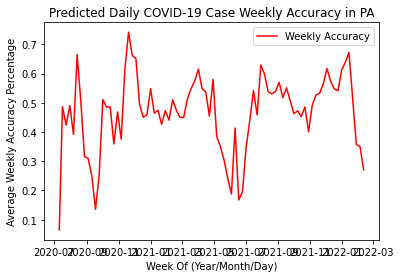

In [37]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [38]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [39]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

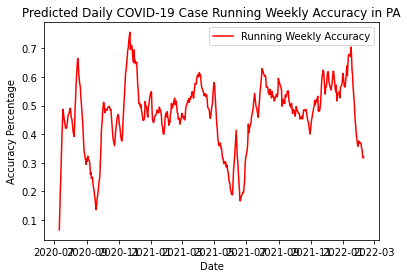

In [40]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

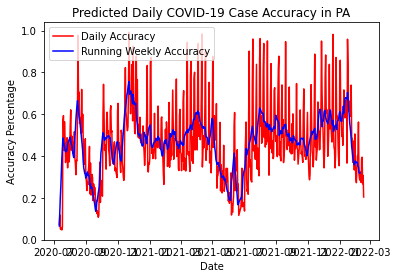

In [41]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [42]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [43]:
#del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

20

In [44]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

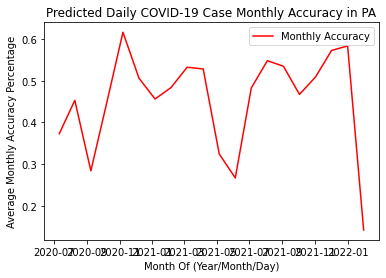

In [45]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [46]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [47]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

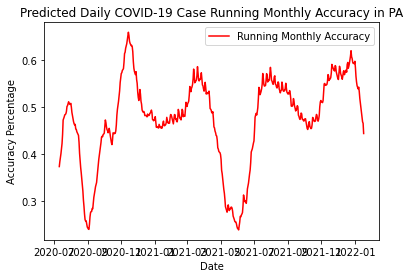

In [48]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [49]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [50]:
print(averageYearlyAccuracy)

[0.43755457994736485, 0.18705863982913246]


In [51]:
#Create Dataframe for Yearly Accuracy
i = 0
data = []
while i < len(averageYearlyAccuracy):
  data.append([weeklyDateListForYears[i], averageYearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Year Of', 'Average Yearly Accuracy'])

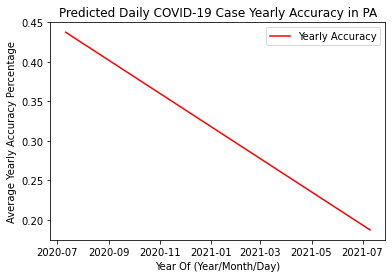

In [52]:
#Create plot of Yearly Accuracy

#Accuracy Line
plt.plot(df['Year Of'], df['Average Yearly Accuracy'], color='r', label='Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Year Of (Year/Month/Day)') 
plt.ylabel('Average Yearly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [53]:
#Calculate Running Yearly Accuracy

runningyearlyAccuracy = 0
runningAverageyearlyAccuracy = []
length = len(accuracy)

i = 1
j = 366
#Add first week average
runningAverageyearlyAccuracy.append(averageYearlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningyearlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageyearlyAccuracy.append(runningyearlyAccuracy / 365)
  runningyearlyAccuracy = 0

  i += 1
  j += 1

In [54]:
#Create Dataframe for Running Yearly Accuracy
i = 0
data = []
while i < len(runningAverageyearlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageyearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Yearly Average Accuracy'])

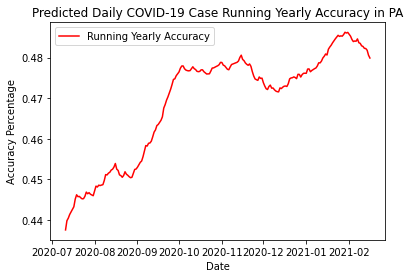

In [55]:
#Create plot of Running Yearly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Yearly Average Accuracy'], color='r', label='Running Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [56]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.46816908741576335


In [57]:
#Create new dataframe for year 2022
data_2022 = merged_df_new[(merged_df_new['Date'] > '2022-01-01')]

In [58]:
#create error and accuracy lists for 2022
error_2022=[]
for index, row in data_2022.iterrows():
  error_2022.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

accuracy_2022 = []
for i in error_2022:
  accuracy_2022.append(1 - i)

In [59]:
#check head of 2022 data
data_2022.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
540,2022-01-02,35128,38695.9,4203914,25603978,6449.2,7426.4,1172327.7,2860489,-5275.682283,2774.207671,30147.571429,0.141779,0.858221,-0.141779
541,2022-01-03,48768,41456.9,4252682,25603978,9816.9,8055.2,1182144.5,2860489,-5275.682283,2774.207671,30147.571429,0.381817,0.618183,-0.381817
542,2022-01-04,51898,44396.0,4304580,25603978,10744.4,8691.2,1192888.2,2860489,-5275.682283,2774.207671,30147.571429,0.419100,0.580900,-0.419100
543,2022-01-05,61004,47411.2,4365584,25603978,11662.5,9215.5,1204551.4,2860489,-5275.682283,2774.207671,30147.571429,0.505810,0.494190,-0.505810
544,2022-01-06,58492,49136.1,4424076,25603978,12854.6,9728.8,1217406.1,2860489,-5275.682283,2774.207671,30147.571429,0.484586,0.515414,-0.484586


([<matplotlib.axis.XTick at 0x7fb1206cf450>,
 <a list of 7 Text major ticklabel objects>)

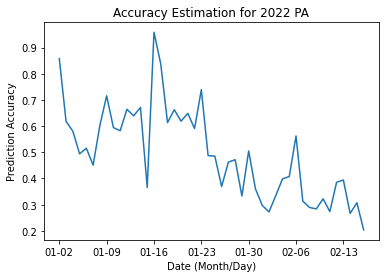

In [60]:
#create plot for 2022 accuracy
plt.xlabel('Date (Month/Day)') 
plt.ylabel('Prediction Accuracy') 
plt.title("Accuracy Estimation for 2022 PA")

plt.plot(data_2022['Date'].dt.strftime('%m-%d'), accuracy_2022, label='Accuracy 2022')
plt.xticks(np.arange(0, len(data_2022['Date']), 7))

In [61]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.07219257575757576, 0.11823101736972708, 0.05213030634573301, 0.04822580971659918, 0.05740614457831328, 0.04599140926640932, 0.0602365360303414, 0.5684473586911898, 0.5930288660940521, 0.4264736257624864, 0.564063445899227, 0.48706033397291737, 0.3684646187318208, 0.39786161460525704, 0.45748799570865084, 0.4872723704292662, 0.3433258536602536, 0.47671997514608455, 0.40988519221213193, 0.3716238137931245, 0.4190651517241617, 0.5426872294372295, 0.6207514236197078, 0.42792541389315586, 0.49539913060659957, 0.44218959435626104, 0.4675895188362551, 0.43679703832752614, 0.4105912596401028, 0.5160581583198707, 0.39051344743276284, 0.3601352874859076, 0.3101359223300971, 0.3784834123222749, 0.3771428571428572, 0.630391604010025, 0.9777502429543246, 0.661331069237511, 0.7057084404956745, 0.5556544550810014, 0.5842653890824623, 0.5389848214285714, 0.5079797619047619, 0.7188392857142858, 0.5131108706108707, 0.5999760967379077, 0.47697630225799237, 0.35815259358737617, 0.36633155906593395, 0.3

In [62]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.03284065285375663
0.18121990192513798


In [63]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.4430598584596286


In [64]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021
# Omicron: December 1st 2021 - Present

In [65]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [67]:
merged_df_new.index[merged_df_new['Date']=='2021-05-20'].tolist()

[313]

In [68]:
merged_df_new.index[merged_df_new['Date']=='2021-12-01'].tolist()

[508]

In [69]:
#print(merged_inner)
standardVariantDF = merged_df_new[:313]
deltaVariantDF = merged_df_new[313:508]
omicronVariantDF = merged_df_new[508:]

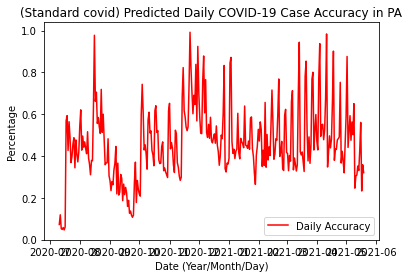

In [70]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

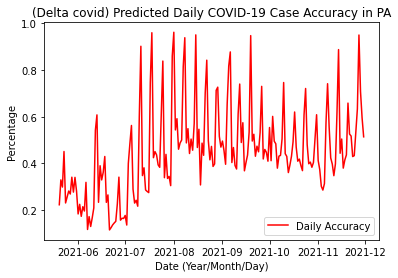

In [71]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

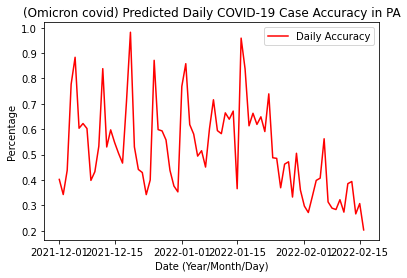

In [72]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(omicronVariantDF['Date'], omicronVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Omicron covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()